In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating environment at `/home/sman/Work/CMU/Courses/OCRL/OCRL2024/HW/HW3_S24/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Installed MUMPS_seq_jll ─────── v5.4.1+0
   Installed ConcurrentUtilities ─ v2.4.1
   Installed Ipopt ─────────────── v1.6.2
   Installed NBInclude ─────────── v2.3.0
   Installed DataStructures ────── v0.18.18
   Installed HTTP ──────────────── v1.10.4
   Installed MeshCat ───────────── v0.16.1
   Installed Ipopt_jll ─────────── v300.1400.400+0
   Installed Format ────────────── v1.3.6
   Installed OpenSSL ───────────── v1.4.2
   Installed StructArrays ──────── v0.6.18
   Installed StaticArrays ──────── v1.9.3
   Installed ChainRulesCore ────── v1.23.0
   Installed MathOptInterface ──── v1.27.0
   Installed PlotUtils ─────────── v1.4.1
   Installed Glib_jll ──────────── v2.80.0+0
   Installed Cairo_jll ─────────── v1.18.0+1
   Installed BenchmarkTools ────── v1.5.0
   Installed Preferences ───────── v1.4.3
   Installed SoftGlobalScop

In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

## Q1: Direct Collocation (DIRCOL) for a Cart Pole (30 pts)

We are now going to start working with the NonLinear Program (NLP) Solver IPOPT to solve some trajectory optimization problems. First we will demonstrate how this works for simple optimization problems (not trajectory optimization). The interface that we have setup for IPOPT is the following:

$$ \begin{align} \min_{x} \quad & \ell(x) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(x) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(x) \leq c_U & \text{inequality constraint}\\
 & x_L \leq x \leq x_U & \text{primal bound constraint}
 \end{align}$$
 
 where $\ell(x)$ is our objective function, $c_{eq}(x) = 0$ is our equality constraint, $c_L \leq c_{ineq}(x) \leq c_U$ is our bound inequality constraint, and $x_L \leq x \leq x_U $ is a bound constraint on our primal variable $x$. 
<!-- $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$ -->

## Part A: Solve an LP with IPOPT (5 pts)
To demonstrate this, we are going to ask you to solve a simple Linear Program (LP):
 
 $$ \begin{align} \min_{x} \quad & q^Tx\\ 
 \text{st} \quad & Ax = b \\
 & Gx \leq h
 \end{align}$$
 
 Your job will be to transform this problem into the form shown above and solve it with IPOPT.  To help you interface with IPOPT, we have created a function `fmincon` for you. Below is the docstring for this function that details all of the inputs. 

In [3]:
"""
x = fmincon(cost,equality_constraint,inequality_constraint,x_l,x_u,c_l,c_u,x0,params,diff_type)

This function uses IPOPT to minimize an objective function 

`cost(params, x)` 

With the following three constraints: 

`equality_constraint(params, x) = 0`
`c_l <= inequality_constraint(params, x) <= c_u` 
`x_l <= x <= x_u` 

Note that the constraint functions should return vectors. 

Problem specific parameters should be loaded into params::NamedTuple (things like 
cost weights, dynamics parameters, etc.). 

args:
    cost::Function                    - objective function to be minimzed (returns scalar)
    equality_constraint::Function     - c_eq(params, x) == 0 
    inequality_constraint::Function   - c_l <= c_ineq(params, x) <= c_u 
    x_l::Vector                       - x_l <= x <= x_u 
    x_u::Vector                       - x_l <= x <= x_u 
    c_l::Vector                       - c_l <= c_ineq(params, x) <= c_u 
    c_u::Vector                       - c_l <= c_ineq(params, x) <= c_u 
    x0::Vector                        - initial guess 
    params::NamedTuple                - problem parameters for use in costs/constraints 
    diff_type::Symbol                 - :auto for ForwardDiff, :finite for FiniteDiff 
    verbose::Bool                     - true for IPOPT output, false for nothing 

optional args:
    tol                               - optimality tolerance 
    c_tol                             - constraint violation tolerance 
    max_iters                         - max iterations 
    verbose                           - verbosity of IPOPT 

outputs:
    x::Vector                         - solution 

You should try and use :auto for your `diff_type` first, and only use :finite if you 
absolutely cannot get ForwardDiff to work. 

This function will run a few basic checks before sending the problem off to IPOPT to 
solve. The outputs of these checks will be reported as the following:

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

If you're getting stuck during the testing of one of the derivatives, try switching 
to FiniteDiff.jl by setting diff_type = :finite. 
""";

In [16]:
@testset "solve LP with IPOPT" begin 
        
    LP = jldopen(joinpath(@__DIR__,"utils","random_LP.jld2"))
    
    params = (q = LP["q"], A = LP["A"], b = LP["b"], G = LP["G"], h = LP["h"])
    
    # return a scalar 
    function cost(params, x)::Real
        # TODO: create cost function with params and x 
        return params.q'*x
    end
    
    # return a vector 
    function equality_constraint(params, x)::Vector
        # TODO: create equality constraint function with params and x 
        return params.A*x - params.b
    end
    
    # return a vector
    function inequality_constraint(params, x)::Vector
        # TODO: create inequality constraint function with params and x 
        return params.G*x - params.h
    end

    # TODO: primal bounds 
    # you may use Inf, like Inf*ones(10) for a vector of positive infinity 
    x_l = -Inf*ones(20)
    x_u = Inf*ones(20)
    
    # TODO: inequality constraint bounds 
    c_l = -Inf*ones(20)
    c_u = zeros(20)
    
    # initial guess 
    x0= randn(20)
    
    diff_type = :auto   # use ForwardDiff.jl
#     diff_type = :finite # use FiniteDiff.jl
    
    x = fmincon(cost, equality_constraint, inequality_constraint,
                x_l, x_u, c_l, c_u, x0, params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true);
    
    
    @test isapprox(x, [-0.44289, 0, 0, 0.19214, 0, 0, -0.109095,
                       -0.43221, 0, 0, 0.44289, 0, 0, 0.192142,
                       0, 0, 0.10909, 0.432219, 0, 0], atol = 1e-3)

end

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints.......

Test.DefaultTestSet("solve LP with IPOPT", Any[], 1, false, false)

## Part B: Cart Pole Swingup (20 pts)

We are now going to solve for a cartpole swingup. The state for the cartpole is the following: 

$$ x = [p,\theta,\dot{p},\dot{\theta}]^T $$ 

Where $p$ and $\theta$ can be seen in the graphic `cartpole.png`.

<div>
<img src="cartpole.png" width="300"/>
</div>

where we start with the pole in the down position ($\theta = 0$), and we want to use the horizontal force on the cart to drive the pole to the up position ($\theta = \pi$).

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{goal})^TQ(x_i - x_{goal}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N - x_{goal})^TQ_f(x_N - x_{goal})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_N = x_{goal} \\ 
 & f_{hs}(x_i,x_{i+1},u_i,dt) = 0 \quad \text{for } i = 1,2,\ldots,N-1 \\
 & -10 \leq u_i \leq 10 \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 
 Where $x_{IC} = [0,0,0,0]$, and $x_{goal} = [0, \pi, 0, 0]$, and $f_{hs}(x_i,x_{i+1},u_i)$ is the implicit integrator residual for Hermite Simpson (see HW1Q1 to refresh on this). Note that while Zac used a first order hold (FOH) on the controls in class (meaning we linearly interpolate controls between time steps), we are using a zero-order hold (ZOH) in this assignment. This means that each control $u_i$ is held constant for the entirety of the timestep. 

In [54]:
# cartpole 
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    ẋ_k = dynamics(params, x1, u)
    ẋ_kp1 = dynamics(params, x2, u)
    x_kpm = 1/2*(x1 + x2) + dt/8*(ẋ_k - ẋ_kp1)
    ẋ_kpm = dynamics(params, x_kpm, u)
    res = x1 + dt/6*(ẋ_k + 4*ẋ_kpm + ẋ_kp1) - x2
    return res
end

hermite_simpson (generic function with 1 method)

To solve this problem with IPOPT and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector:

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.

It is also worth noting that while there are inequality constraints present ($-10 \leq u_i \leq 10$), we do not need a specific `inequality_constraints` function as an input to `fmincon` since these are just bounds on the primal ($Z$) variable. You should use primal bounds in `fmincon` to capture these constraints.  

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    34272
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints.......

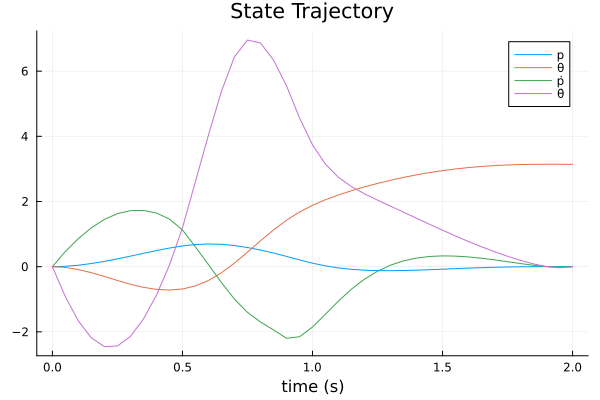

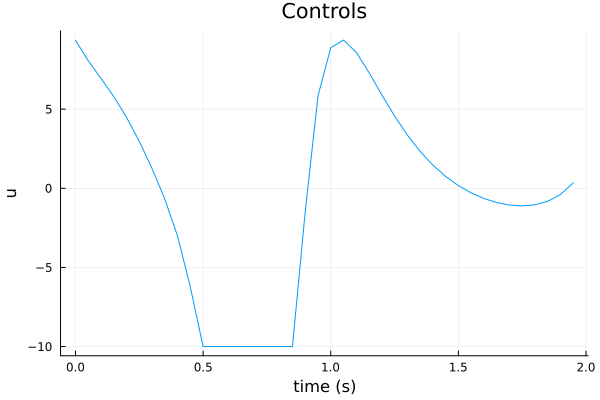

┌ Info: Listening on: 127.0.0.1:8720, thread id: 1
└ @ HTTP.Servers /root/.julia/packages/HTTP/enKbm/src/Servers.jl:369
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8720
└ @ MeshCat /root/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8720, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8720), "127.0.0.1", "8720", nothing, Sockets.TCPServer(RawFD(110) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007f387c51fb20)))

Test Summary:    | Pass  Total
cartpole swingup |    2      2


Test.DefaultTestSet("cartpole swingup", Any[], 2, false, false)

In [60]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x=x,u=u,c=c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        J += 1 / 2 *( (xi - xg)' * Q * (xi - xg) + ui' * R * ui)
    end
    
    xn = Z[idx.x[N]]
    # dont forget terminal cost 
    J += 1 / 2 * (xn - xg)' * Qf * (xn - xg)

    return J
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)

    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end

    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints 
    x0 = Z[idx.x[1]]
    xN = Z[idx.x[N]]
    eq_cons = [cartpole_dynamics_constraints(params, Z); x0 - xic; xN - xg]
    
    return eq_cons
end

function solve_cartpole_swingup(;verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.05
    tf = 2.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, 0, 0]
    xg = [0, pi, 0, 0]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
    
    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u =  Inf*ones(idx.nz)

    for i = 1:(N-1)
        x_l[idx.u[i]] .= -10
        x_u[idx.u[i]] .= 10
    end
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
    # diff_type = :finite


    Z = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

@testset "cartpole swingup" begin 
    
    X, U, t_vec = solve_cartpole_swingup(verbose=true)
    
    
    # --------------testing------------------
    @test isapprox(X[1],zeros(4), atol = 1e-4)
    @test isapprox(X[end], [0,pi,0,0], atol = 1e-4)
    Xm = hcat(X...)
    Um = hcat(U...)
    
    # --------------plotting-----------------
    display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
    display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
    
    # meshcat animation
    display(animate_cartpole(X, 0.05))
    
end

## Part C: Track DIRCOL Solution (5 pts)

Now, similar to HW2 Q2 Part C, we are taking a solution $X$ and $U$ from DIRCOL, and we are going to track the trajectory with TVLQR to account for model mismatch. While we used hermite-simpson integration for the dynamics constraints in DIRCOL, we are going to use RK4 for this simulation. Remember to clamp your control to be within the control bounds. 

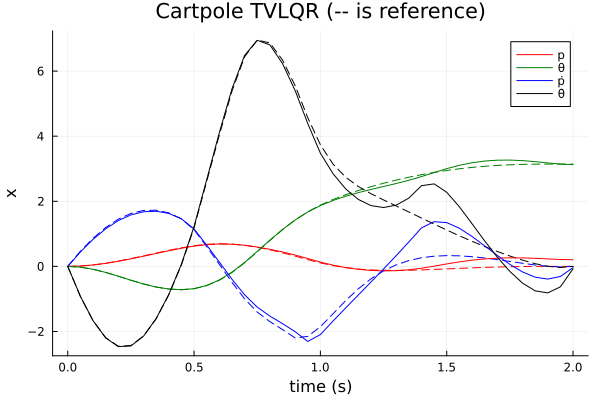

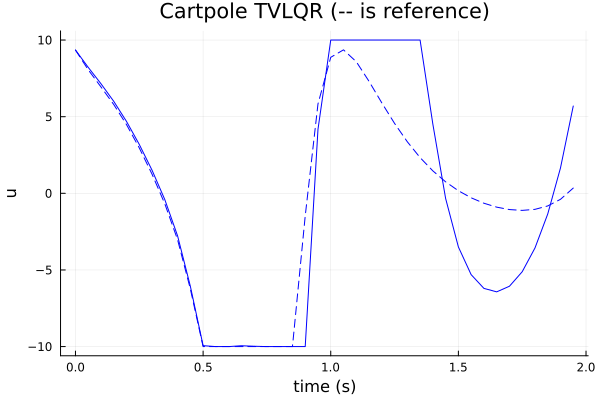

┌ Info: Listening on: 127.0.0.1:8722, thread id: 1
└ @ HTTP.Servers /root/.julia/packages/HTTP/enKbm/src/Servers.jl:369
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8722
└ @ MeshCat /root/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8722, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8722), "127.0.0.1", "8722", nothing, Sockets.TCPServer(RawFD(114) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007f390b70d3c0)))

Test Summary:                     | Pass  Total
track cartpole swingup with TVLQR |    4      4


Test.DefaultTestSet("track cartpole swingup with TVLQR", Any[], 4, false, false)

In [69]:
function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

@testset "track cartpole swingup with TVLQR" begin 
    
    X_dircol, U_dircol, t_vec, params_dircol = solve_cartpole_swingup(verbose = false)
    
    N = length(X_dircol)
    dt = params_dircol.dt 
    x0 = X_dircol[1]
    
    # TODO: use TVLQR to generate K's 


    # use this for TVLQR tracking cost 
    Q = diagm([1,1,.05,.1])
    Qf = 100*Q
    R = 0.01*diagm(ones(1))

    nx = 4
    nu = 1

    P = Qf
    Ks = [zeros(nx) for i = 1:N-1]
    Dc = zeros(nx+nu,nx+nu)
    u = 0

    for ii = N:-1:2  
        # convert to dicrete dynamics     
        Ac = ForwardDiff.jacobian(_x -> dynamics(params_dircol, _x, U_dircol[ii-1]), X_dircol[ii])       
        Bc = ForwardDiff.jacobian(_u -> dynamics(params_dircol, X_dircol[ii], _u), U_dircol[ii-1])       
        Dc[1:nx, 1:nx+nu] = [Ac Bc]       
        Dd = exp(Dc*dt)     
        A, B = (Dd[1:nx, 1:nx], Dd[1:nx, (nx+1):(nx+nu)])      
        # riccati recursion   
        K = (R + B'*P*B) \ B'*P*A       
        Ks[ii-1] = vec(K)       
        P = Q + K'*R*K + (A-B*K)'*P*(A-B*K)   
    end
    
    # simulation
    Xsim = [zeros(4) for i = 1:N]
    Usim = [zeros(1) for i = 1:(N-1)]
    Xsim[1] = 1*x0 
    
    # here are the real parameters (different than the one we used for DIRCOL)
    # this model mismatch is what's going to require the TVLQR controller to track
    # the trajectory successfully. 
    params_real = (mc = 1.05, mp = 0.21, l = 0.48)
    
    # TODO: simulate closed loop system with both feedforward and feedback control
    # feedforward - the U_dircol controls that we solved for using dircol 
    # feedback - the TVLQR controls 
    for i = 2:N

        # add controller and simulation step 
        Usim[i-1] = clamp.(U_dircol[i-1]-[Ks[i-1]⋅(Xsim[i-1] - X_dircol[i-1])], -10, 10)
        Xsim[i] = rk4(params_real, Xsim[i-1],Usim[i-1], dt)
    end
    
    
    # -----------------testing-----------------------
    xn = Xsim[N]
    @test norm(xn)>0
    @test 1e-6<norm(xn - X_dircol[end])<.8
    @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
    @test maximum(norm.(Usim,Inf)) <= (10 + 1e-3)
    
    # -----------------plotting----------------------
    Xm = hcat(Xsim...)
    Xbarm = hcat(X_dircol...)
    plot(t_vec,Xbarm',ls=:dash, label = "",lc = [:red :green :blue :black])
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time (s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))
    
    Um = hcat(Usim...)
    Ubarm = hcat(U_dircol...)
    plot(t_vec[1:end-1],Ubarm',ls=:dash,lc = :blue, label = "")
    display(plot!(t_vec[1:end-1],Um',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time (s)", ylabel = "u",lc = :blue, label = ""))
    
    # ----------------animate------------------------
    display(animate_cartpole(Xsim, 0.05))
    
end